In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import os

os.environ["USE_PYGEOS"] = "0"

import os
import shutil

import geopandas
import napari
import numpy as np
import spatialdata as sd
from napari_spatialdata import Interactive
from shapely.geometry import Polygon
from spatialdata.transformations import (
    Affine,
    Identity,
    Sequence,
    align_elements_using_landmarks,
    get_transformation,
    set_transformation,
)

In [3]:
print("current working directory:", os.getcwd())
SPATIALDATA_SANDBOX_PATH = "spatialdata-sandbox"
assert os.path.isdir(
    SPATIALDATA_SANDBOX_PATH
), f"{SPATIALDATA_SANDBOX_PATH} not found, please use symlinks to make it available"
GENERATED_DATA_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "generated_data/xenium_visium_integration")
assert os.path.isdir(GENERATED_DATA_PATH), f"{GENERATED_DATA_PATH} not found, please use symlinks to make it available"


XE_REP1_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep1_io/data_aligned.zarr")
XE_REP2_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep2_io/data_aligned.zarr")
VISIUM_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "visium_associated_xenium_io/data_aligned.zarr")
# XE_REP1_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep1_io/data.zarr")
# XE_REP2_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep2_io/data.zarr")
# VISIUM_PATH = os.path.join(
#     SPATIALDATA_SANDBOX_PATH, "visium_associated_xenium_io/data.zarr"
# )
assert os.path.isdir(XE_REP1_PATH), XE_REP1_PATH
assert os.path.isdir(XE_REP2_PATH), XE_REP2_PATH
assert os.path.isdir(VISIUM_PATH), VISIUM_PATH

XE_REP1_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep1_roi.zarr")
XE_REP2_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep2_roi.zarr")
VISIUM_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "visium_roi.zarr")

LANDMARKS_SDATA_PATH = os.path.join(GENERATED_DATA_PATH, "sandbox.zarr")

current working directory: /Users/macbook/embl/projects/basel/spatialdata-notebooks/notebooks/paper_reproducibility


In [4]:
# we delete some elements (in-memory only) because we will not need them in napari
xe_rep1_sdata = sd.read_zarr(XE_REP1_PATH)
del xe_rep1_sdata.images["morphology_focus"]
del xe_rep1_sdata.shapes["cell_boundaries"]
del xe_rep1_sdata.shapes["nucleus_boundaries"]
xe_rep2_sdata = sd.read_zarr(XE_REP2_PATH)
del xe_rep2_sdata.images["morphology_focus"]
del xe_rep2_sdata.shapes["cell_boundaries"]
del xe_rep2_sdata.shapes["nucleus_boundaries"]
visium_sdata = sd.read_zarr(VISIUM_PATH)

xe_rep1_roi_sdata = sd.read_zarr(XE_REP1_ROI_PATH)
# del xe_rep1_roi_sdata.shapes["cell_boundaries"]
del xe_rep1_roi_sdata.shapes["nucleus_boundaries"]
xe_rep2_roi_sdata = sd.read_zarr(XE_REP2_ROI_PATH)
# del xe_rep2_roi_sdata.shapes["cell_boundaries"]
del xe_rep2_roi_sdata.shapes["nucleus_boundaries"]
visium_roi_sdata = sd.read_zarr(VISIUM_ROI_PATH)

landmarks_sdata = sd.read_zarr(LANDMARKS_SDATA_PATH)

In [5]:
landmarks_sdata["rois"]["name"] = [
    "Invasive",
    "Immune infiltration",
    "DCIS",
    "Duct ectasia",
]
# the new extra column gets not saved to Zarr, we need to discuss this behavior (and the relationships with multiple tables) in the next hackathon
landmarks_sdata["rois"]

geometry                 name
0  POLYGON ((1928.166 9124.230, 1928.166 9151.215...             Invasive
1  POLYGON ((8109.926 14163.968, 8109.926 14173.7...  Immune infiltration
2  POLYGON ((32042.805 22387.401, 32026.302 22436...                 DCIS
3  POLYGON ((27504.676 20232.314, 27514.049 20237...         Duct ectasia

In [6]:
# remove the cells, for xenium rep 2, inside the box (so already present in xenium rep 1)
xe_rep2_sdata.shapes["cell_circles"] = xe_rep2_sdata["cell_circles"][
    ~xe_rep2_sdata["cell_circles"].index.isin(xe_rep2_roi_sdata["cell_circles"].index)
]

In [7]:
from anndata import AnnData


def set_colors_for_categorical_obs(adata: AnnData, column: str, colors_dict: dict[str, str]):
    colors = []
    for cat in adata.obs[column].cat.categories.tolist():
        color = colors_dict[cat]
        colors.append(color)
    adata.uns[f"{column}_colors"] = colors


celltype_major_colors = {
    "B-cells": "#d8f55e",
    "CAFs": "#532C8A",
    "Cancer Epithelial": "#C72228",
    "Endothelial": "#9e6762",
    "Myeloid": "#ffe012",
    "T-cells": "#3cb44b",
    "Normal Epithelial": "#0F4A9C",
    "PVL": "#c09d9a",
    "Plasmablasts": "#000075",
}
set_colors_for_categorical_obs(
    adata=xe_rep1_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)
set_colors_for_categorical_obs(
    adata=xe_rep2_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)

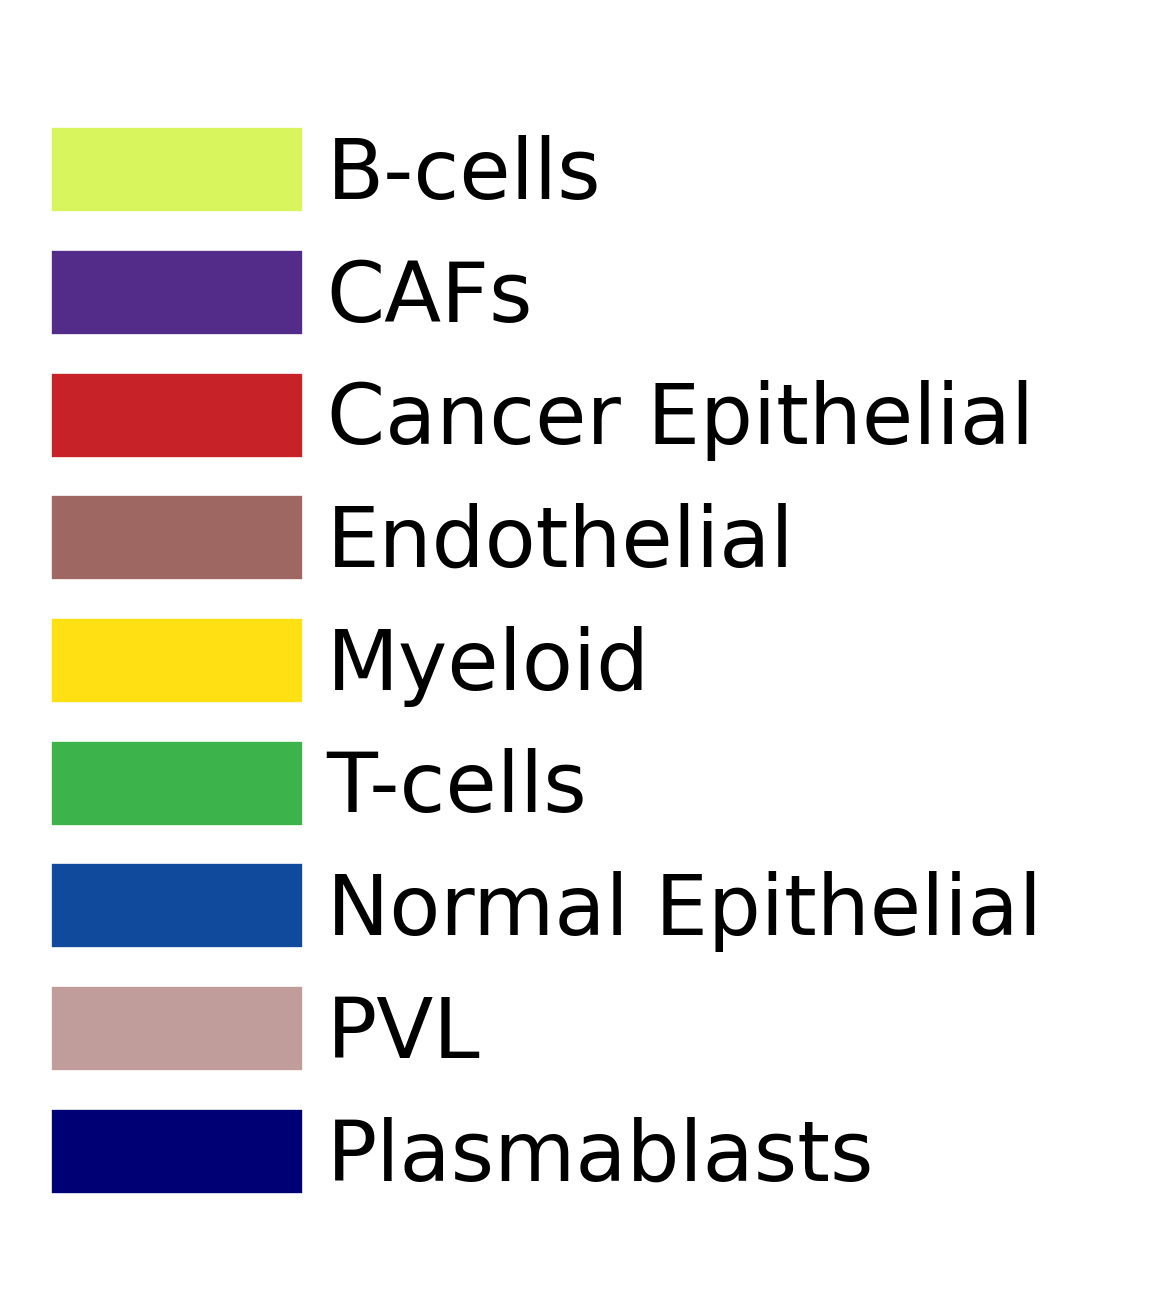

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2, 1), dpi=600)

for label, color in celltype_major_colors.items():
    ax.plot([], [], label=label, color=color, linestyle="-", linewidth=10)

ax.legend(loc="best", frameon=False)
ax.axis("off")
plt.show()

In [9]:
xe_rep1_roi_sdata.table.obs["celltype_major"] = xe_rep1_roi_sdata.table.obs["celltype_major"].astype("category")
xe_rep1_roi_sdata.table.obs["celltype_minor"] = xe_rep1_roi_sdata.table.obs["celltype_minor"].astype("category")
xe_rep2_roi_sdata.table.obs["celltype_major"] = xe_rep2_roi_sdata.table.obs["celltype_major"].astype("category")
xe_rep2_roi_sdata.table.obs["celltype_minor"] = xe_rep2_roi_sdata.table.obs["celltype_minor"].astype("category")

set_colors_for_categorical_obs(
    adata=xe_rep1_roi_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)
set_colors_for_categorical_obs(
    adata=xe_rep2_roi_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)

In [10]:
clone_colors = {
    "1": "#DA1F26",
    "2": "#3C8F35",
    "3": "#7BB0DF",
    "diploid": "#00000000",
    "not detected": "#00000000",
    # "diploid": "#1966B0",
    # "not detected": "#892F73",
}

set_colors_for_categorical_obs(
    adata=visium_sdata.table,
    column="clone",
    colors_dict=clone_colors,
)

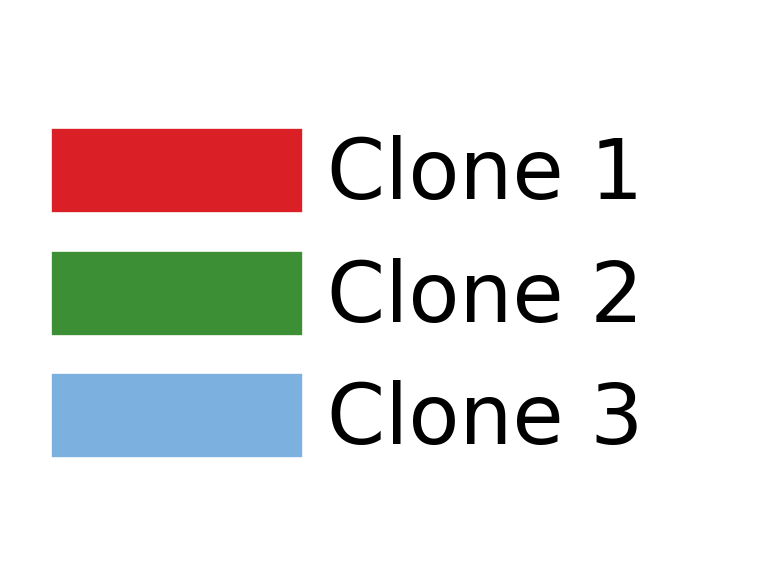

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1, 1), dpi=600)

for label, color in {f"Clone {k}": v for k, v in clone_colors.items() if k in ["1", "2", "3"]}.items():
    ax.plot([], [], label=label, color=color, linestyle="-", linewidth=10)

ax.legend(loc="best", frameon=False)
ax.axis("off")
plt.show()

In [12]:
visium_sdata

SpatialData object with:
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': SpatialImage[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': SpatialImage[cyx] (3, 600, 543)
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs', 'clone_colors'
    obsm: 'spatial': AnnData (4992, 18085)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
▸ 'downscaled_hires', with elements:


In [13]:
table_clones = visium_sdata.table[visium_sdata.table.obs["clone"].isin(["1", "2", "3"])]

In [14]:
table_clones.obs.spot_id

AACAGGTTCACCGAAG-1       7
AACAGTCAGGCTCCGC-1       8
AACAGTCCACGCGGTG-1       9
AACATCTAATGACCGG-1      15
AACATCTTAAGGCTCA-1      16
                      ... 
TGTCGAGTGCGTTAGC-1    4962
TGTCTAAGCAGACGTA-1    4966
TGTCTACTAGATTGCC-1    4967
TGTTCACTGTCTTCCT-1    4975
TGTTGGATGGACTTCT-1    4989
Name: spot_id, Length: 1513, dtype: int64

In [15]:
circles_clones = visium_sdata["CytAssist_FFPE_Human_Breast_Cancer"].loc[table_clones.obs.spot_id]

In [16]:
only_clones = sd.SpatialData(
    shapes={"CytAssist_FFPE_Human_Breast_Cancer": circles_clones},
    table=table_clones,
    images={
        "CytAssist_FFPE_Human_Breast_Cancer_full_image": visium_sdata["CytAssist_FFPE_Human_Breast_Cancer_full_image"]
    },
)

In [17]:
# Interactive([xe_rep1_sdata, xe_rep2_sdata, visium_sdata, landmarks_sdata], points=False)
# Interactive([only_clones, landmarks_sdata], points=False)
# Interactive([xe_rep1_sdata, xe_rep2_sdata, visium_sdata, landmarks_sdata])
# Interactive([xe_rep1_roi_sdata, xe_rep2_roi_sdata, visium_roi_sdata, landmarks_sdata])
# Interactive([xe_rep1_roi_sdata, xe_rep2_roi_sdata, visium_roi_sdata, landmarks_sdata])
# Interactive([xe_rep1_roi_sdata])
# Interactive([visium_sdata, landmarks_sdata])

In [18]:
from shapely import Polygon
from spatialdata import SpatialData
from spatialdata.models import ShapesModel


# same function of notebooks 00, move to a .py file, later on include a reworked version in spatialdata
def spatial_query_shapes_by_polygon(sdata: SpatialData, polygon: Polygon, target_coordinate_system: str):
    new_shapes = {}
    for shapes_name, shapes in sdata.shapes.items():
        if "__old_index" in shapes.columns:
            assert np.all(shapes["__old_index"] == shapes.index)
        else:
            shapes["__old_index"] = shapes.index
        # indices = shapes.intersects(polygon)
        # indices = shapes.geometry.apply(lambda x: x.intersects(polygon).values.tolist()[0][0])
        indices = shapes.geometry.apply(lambda x: x.intersects(polygon))
        if np.sum(indices) == 0:
            continue
        queried_shapes = shapes[indices]
        queried_shapes.index = queried_shapes["__old_index"]
        del shapes["__old_index"]
        del queried_shapes["__old_index"]
        transformation = get_transformation(shapes, target_coordinate_system)
        queried_shapes = ShapesModel.parse(queried_shapes)
        set_transformation(queried_shapes, transformation, target_coordinate_system)
        new_shapes[shapes_name] = queried_shapes
    if len(new_shapes) == 0:
        raise ValueError("we expect at least one shape")
    return SpatialData(shapes=new_shapes, table=sdata.table)

In [19]:
import pandas as pd
from geopandas import GeoDataFrame
from spatialdata import polygon_query
from spatialdata.models import TableModel


def get_shapes_in_rois_sdata(
    sdata: SpatialData, shapes_name: str, rois: GeoDataFrame, instance_key: str
) -> SpatialData:
    sdatas = []

    for roi in rois.iterrows():
        geometry, name = roi[1]
        sdata_queried = polygon_query(
            SpatialData(shapes={shapes_name: sdata[shapes_name]}),
            geometry,
            "aligned",
        )
        region_name = f"Shapes in ROI {name!r}"
        merged = pd.merge(
            sdata.table.obs[[instance_key]],
            sdata_queried.shapes[shapes_name],
            how="right",
            left_on=instance_key,
            right_index=True,
        )
        filtered_table = sdata.table[merged.index].copy()
        filtered_table.obs["region"] = region_name
        del filtered_table.uns["spatialdata_attrs"]
        TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)

        sdata_queried = SpatialData(shapes={region_name: sdata_queried[shapes_name]}, table=filtered_table)
        sdatas.append(sdata_queried)

    cells_in_rois_sdata = sd.concatenate(sdatas)
    return cells_in_rois_sdata

In [20]:
import pandas as pd
from spatialdata.models import TableModel

cells_in_rois_sdata_rep1 = get_shapes_in_rois_sdata(
    sdata=xe_rep1_roi_sdata, shapes_name="cell_circles", rois=landmarks_sdata["rois"], instance_key="cell_id"
)

cells_in_rois_sdata_rep1.table.obs["celltype_major"] = cells_in_rois_sdata_rep1.table.obs["celltype_major"].astype(
    "category"
)
set_colors_for_categorical_obs(
    adata=cells_in_rois_sdata_rep1.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)

In [21]:
cells_in_rois_sdata_rep2 = get_shapes_in_rois_sdata(
    sdata=xe_rep2_roi_sdata, shapes_name="cell_circles", rois=landmarks_sdata["rois"], instance_key="cell_id"
)

cells_in_rois_sdata_rep2.table.obs["celltype_major"] = cells_in_rois_sdata_rep2.table.obs["celltype_major"].astype(
    "category"
)
set_colors_for_categorical_obs(
    adata=cells_in_rois_sdata_rep2.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)

In [22]:
cells_in_rois_sdata_visium = get_shapes_in_rois_sdata(
    sdata=visium_roi_sdata,
    shapes_name="CytAssist_FFPE_Human_Breast_Cancer",
    rois=landmarks_sdata["rois"],
    instance_key="spot_id",
)

In [24]:
# rois colors (this is the order how the ROIs are saved)
rois_colors = {
    "Invasive": "#4cb1ff",
    "Immune infiltration": "#7dc573",
    "Duct ectasia": "#ffd700",
    "DCIS": "#ff5500",
}

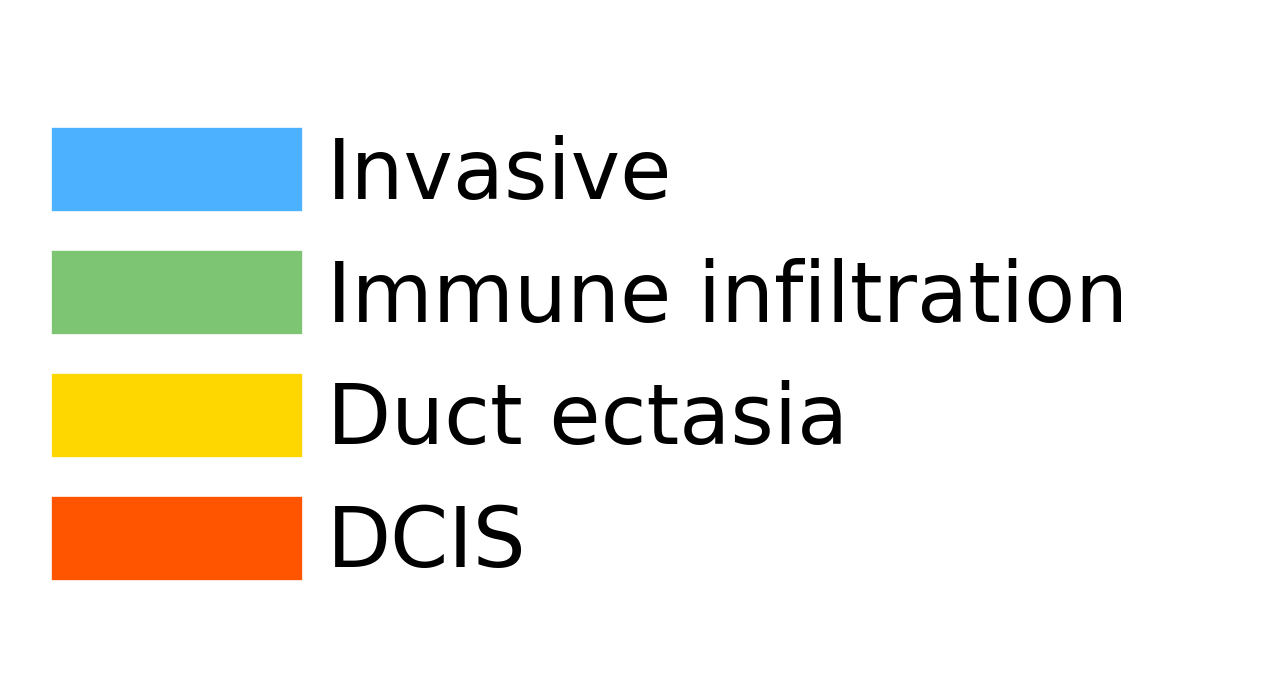

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2, 1), dpi=600)

for label, color in rois_colors.items():
    ax.plot([], [], label=label, color=color, linestyle="-", linewidth=10)

ax.legend(loc="best", frameon=False)
ax.axis("off")
plt.show()

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr


def compute_correlations(X1, X2, axis=1):
    correlations = []
    for i in range(X1.shape[axis]):
        if axis == 1:
            row_correlation1, _ = pearsonr(X1[:, i], X2[:, i])
        elif axis == 0:
            row_correlation1, _ = pearsonr(X1[i, :], X2[i, :])
        correlations.append(row_correlation1)
    return np.array(correlations)

In [27]:
visium_roi_sdata

SpatialData object with:
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (2826, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 2826 × 307
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial', 'xe_rep1_celltype_major', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2_celltype_minor'
    layers: 'xe_rep1_cells', 'xe_rep1_tx', 'xe_rep2_cells', 'xe_rep2_tx': AnnData (2826, 307)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer (Shapes)

[0.7052252595873557, 0.9655842402193482, 0.6991666217877837, nan, 0.7033484522066195, 0.966168395720894, nan, 0.7065554029661046, nan, nan]


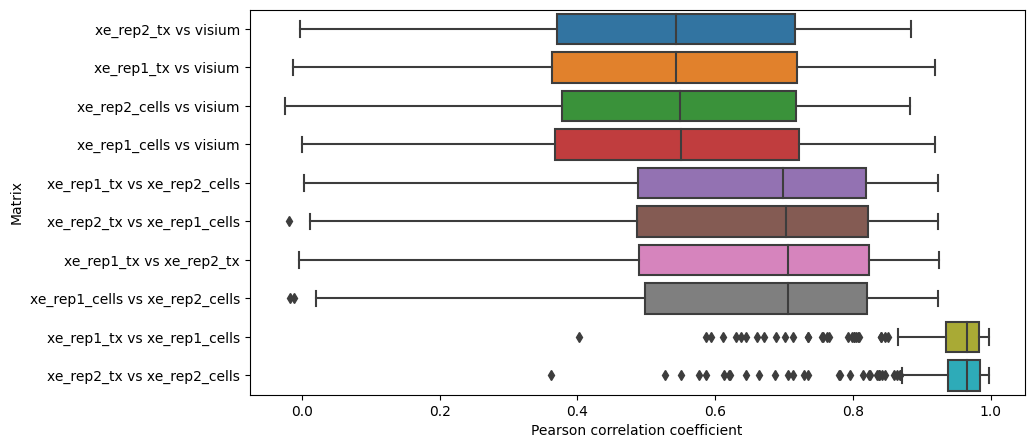

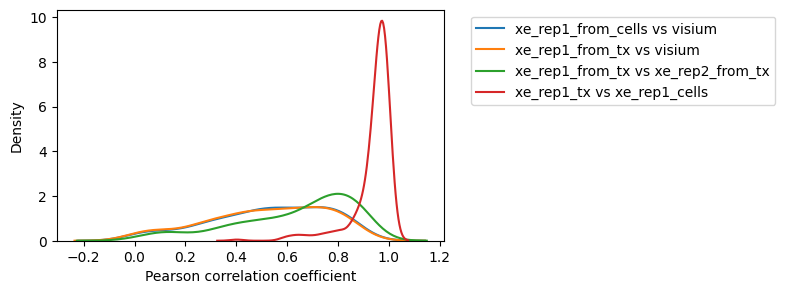

In [28]:
matrices = {
    "xe_rep1_tx": visium_roi_sdata.table.layers["xe_rep1_tx"],
    "xe_rep2_tx": visium_roi_sdata.table.layers["xe_rep2_tx"],
    "xe_rep1_cells": visium_roi_sdata.table.layers["xe_rep1_cells"],
    "xe_rep2_cells": visium_roi_sdata.table.layers["xe_rep2_cells"],
    "visium": visium_roi_sdata.table.X.toarray(),
}
correlations = {}
for i1, (name1, X1) in enumerate(matrices.items()):
    for i2, (name2, X2) in enumerate(matrices.items()):
        if i1 >= i2:
            continue
        corr = compute_correlations(X1, X2)
        # print(np.sum(np.isnan(corr)))
        correlations[(name1, name2)] = corr

sorted_correlations = dict(sorted(correlations.items(), key=lambda x: np.nanmedian(x[1])))
print([np.median(x[1]) for x in correlations.items()])


def plot_correlations_seaborn_boxplot(correlations):
    df = pd.DataFrame(
        np.stack(list(correlations.values())),
        index=[" vs ".join(k) for k in correlations.keys()],
    ).T
    df = df.melt(var_name="Matrix", value_name="Pearson correlation coefficient")

    plt.figure(figsize=(10, 5))
    sns.boxplot(
        x="Pearson correlation coefficient",
        y="Matrix",
        data=df,
        # scale="width",
    )
    plt.show()


plot_correlations_seaborn_boxplot(sorted_correlations)


def plot_correlations_seaborn_densities(correlations):
    df = pd.DataFrame(
        np.stack(list(correlations.values())),
        index=[" vs ".join(k) for k in correlations.keys()],
    ).T
    df = df.melt(var_name="Matrix", value_name="Pearson correlation coefficient")

    plt.figure(figsize=(5, 3))
    for matrix_pair in df["Matrix"].unique():
        sns.kdeplot(
            x=df.loc[df["Matrix"] == matrix_pair, "Pearson correlation coefficient"],
            label=matrix_pair,
            common_norm=False,
            common_grid=True,
            lw=1.5,
        )
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()


plot_correlations_seaborn_densities(
    {
        k: sorted_correlations[(k[0].replace("from_", ""), k[1].replace("from_", ""))]
        for k in [
            ("xe_rep1_from_cells", "visium"),
            ("xe_rep1_from_tx", "visium"),
            ("xe_rep1_from_tx", "xe_rep2_from_tx"),
            # ("xe_rep1_cells", "xe_rep2_cells"),
            ("xe_rep1_tx", "xe_rep1_cells"),
        ]
    }
)

In [29]:
# gene case
corr_last = sorted_correlations[("xe_rep2_tx", "xe_rep2_cells")]
corr_second_last = sorted_correlations[("xe_rep1_tx", "xe_rep1_cells")]


# bad_genes = visium_roi_sdata.table.var_names[np.where(corr_last > 0.995)[0]].tolist()
# bad_genes2 = visium_roi_sdata.table.var_names[
#     np.where(corr_second_last > 0.995)[0]
# ].tolist()

bad_genes = visium_roi_sdata.table.var_names[np.where(corr_last < 0.6)[0]].tolist()
bad_genes2 = visium_roi_sdata.table.var_names[np.where(corr_second_last < 0.6)[0]].tolist()
print(len(bad_genes))
print(len(bad_genes2))

5
3


In [30]:
bad_genes

['MPO', 'CRHBP', 'AHSP', 'GZMK', 'MUC6']

In [31]:
print(set(bad_genes).intersection(set(bad_genes2)))

{'CRHBP', 'MPO', 'GZMK'}


## Panel D

second last row


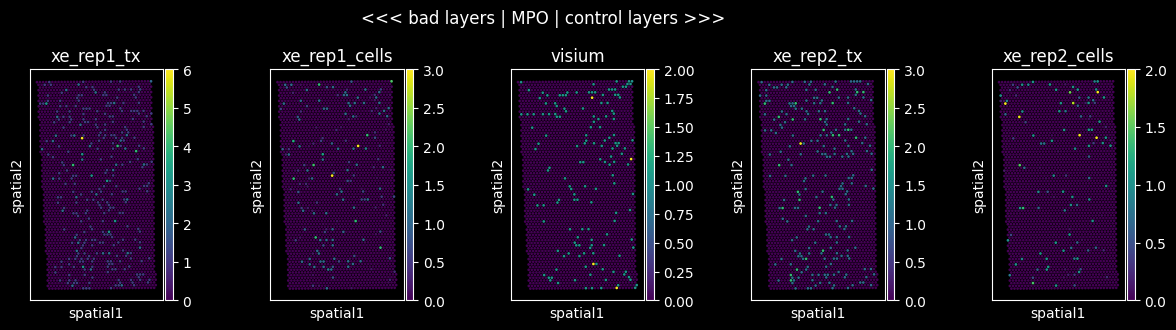

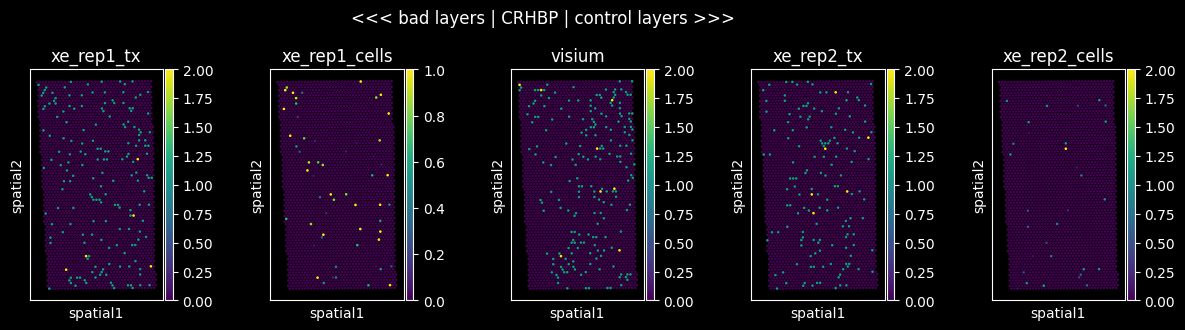

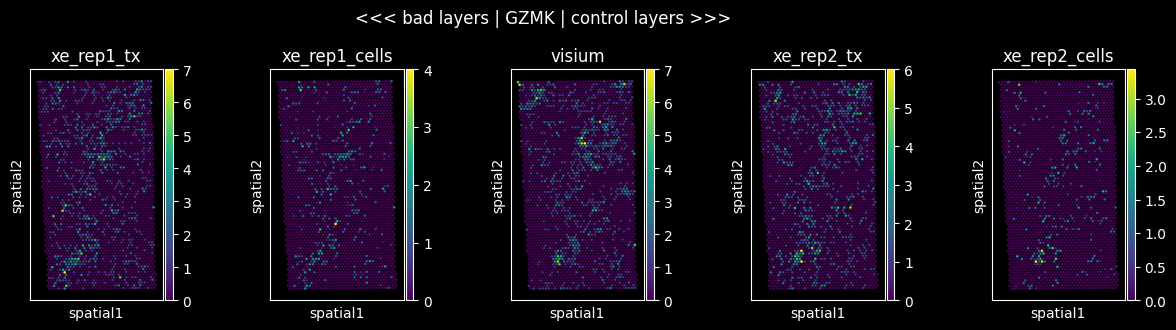

last row


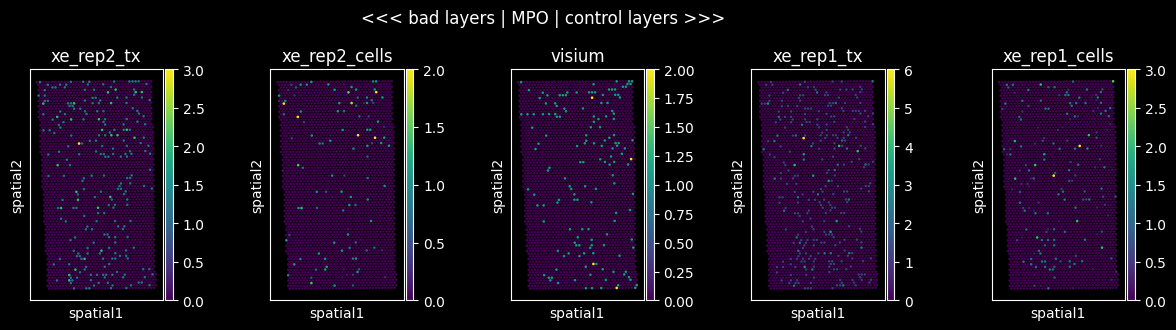

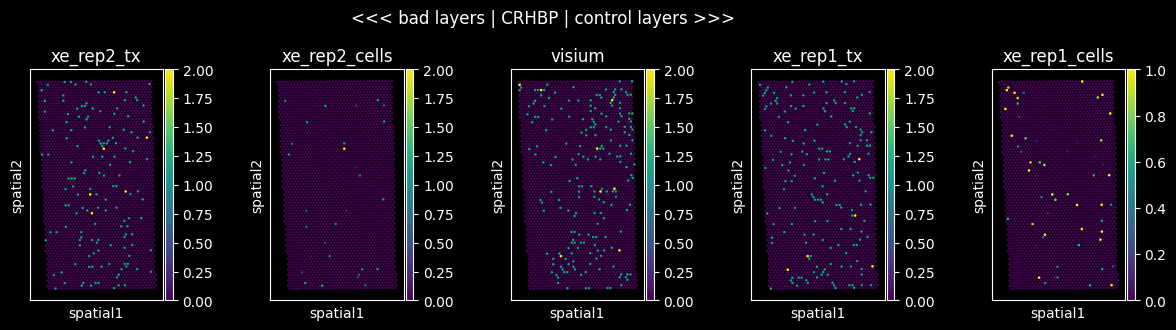

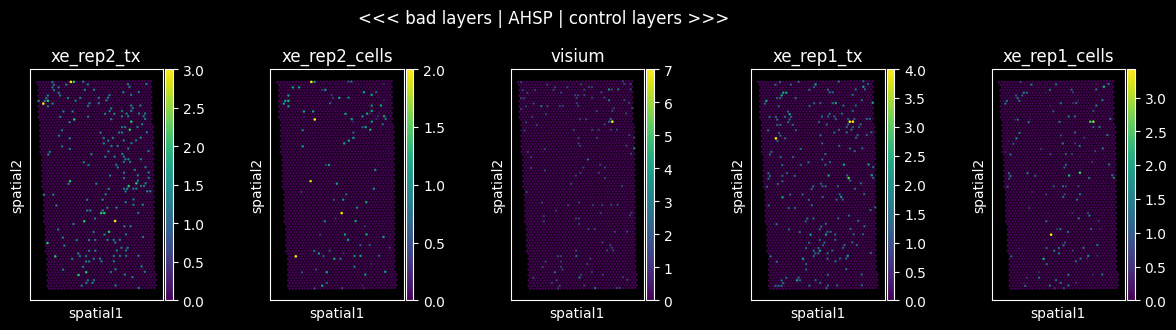

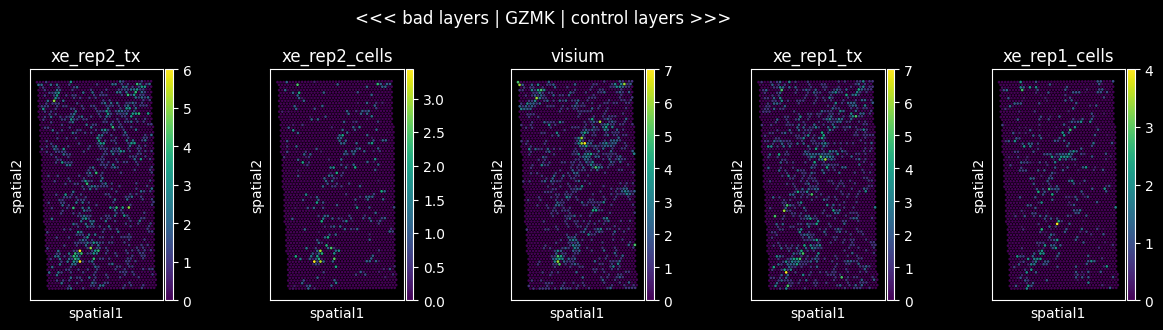

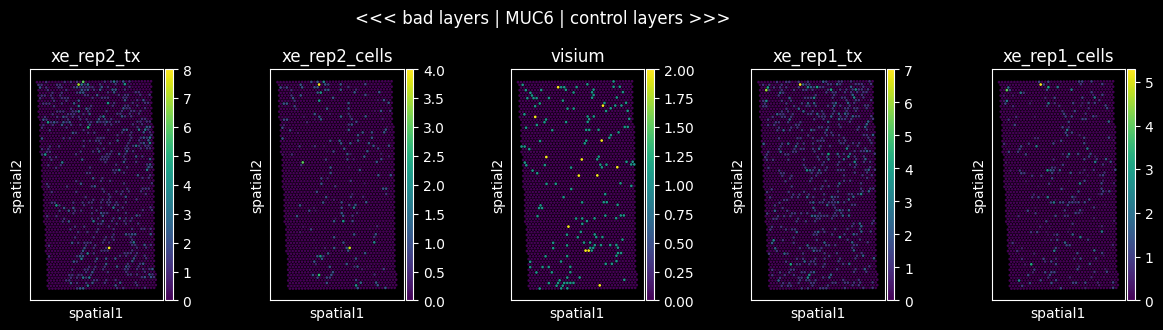

In [32]:
import matplotlib.pyplot as plt
import scanpy as sc

plt.style.use("dark_background")

visium_roi_sdata.table.layers["visium"] = visium_roi_sdata.table.X
for rep in ["rep1", "rep2"]:
    layers = [
        "xe_rep1_tx",
        "xe_rep1_cells",
        "xe_rep2_tx",
        "xe_rep2_cells",
        "visium",
    ]
    if rep == "rep1":
        genes = bad_genes2
        print("second last row")
    else:
        genes = bad_genes
        print("last row")
    bad_layers = [la for la in layers if rep in la] + ["visium"]
    control_layers = [la for la in layers if la not in bad_layers]

    for gene in genes:
        axes = plt.subplots(1, 5, figsize=(15, 3))[1].flatten()
        for i, ax in enumerate(axes):
            layer = (bad_layers + control_layers)[i]
            sc.pl.spatial(
                visium_roi_sdata.table,
                img_key=None,
                library_id=None,
                spot_size=160,
                color=gene,
                layer=layer,
                show=False,
                ax=ax,
                title=layer,
            )
        plt.suptitle(f"<<< bad layers | {gene} | control layers >>>", y=1.08)
    plt.show()

plt.style.use("default")

In [33]:
# to correct the visual appearance of the plot in the fig2, where we rotate the outline figure by 3.056 degrees
theta = -(3.056 / 180) * np.pi
rotation_matrix = np.array(
    [
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)],
    ]
)

In [34]:
spatial = np.array(
    [
        visium_roi_sdata["CytAssist_FFPE_Human_Breast_Cancer"].geometry.x,
        visium_roi_sdata["CytAssist_FFPE_Human_Breast_Cancer"].geometry.y,
    ]
).T
spatial = (rotation_matrix @ spatial.T).T
visium_roi_sdata.table.obsm["spatial"] = spatial

In [35]:
boundary = visium_roi_sdata["CytAssist_FFPE_Human_Breast_Cancer"].unary_union.convex_hull
box_x, box_y = boundary.exterior.xy
box_xy = np.vstack((box_x, box_y))
box_xy = rotation_matrix @ box_xy
box_x, box_y = box_xy

In [36]:
visium_roi_sdata.table.layers["xe_rep1_tx_log"] = np.log1p(visium_roi_sdata.table.layers["xe_rep1_tx"])
visium_roi_sdata.table.layers["xe_rep2_tx_log"] = np.log1p(visium_roi_sdata.table.layers["xe_rep2_tx"])

In [37]:
visium_roi_sdata.table.layers["xe_rep2_tx"].max()

1084

248
xe_rep2_cells vs xe_rep2_tx: 0.6206379236691637
visium vs xe_rep2_tx: 0.025508660130102667
visium vs xe_rep2_cells: 0.023798697515337246
xe_rep1_tx vs xe_rep2_tx: 0.04029178761236513
xe_rep1_tx vs xe_rep2_cells: 0.057849121192654035
xe_rep1_tx vs visium: -0.012635844918520647
xe_rep1_cells vs xe_rep2_tx: 0.01163045211571077
xe_rep1_cells vs xe_rep2_cells: 0.020855620028069802
xe_rep1_cells vs visium: 0.005393090857445667
xe_rep1_cells vs xe_rep1_tx: 0.6608743020750578
visium


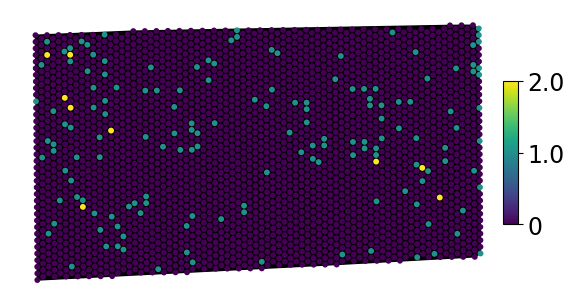

xe_rep1_tx


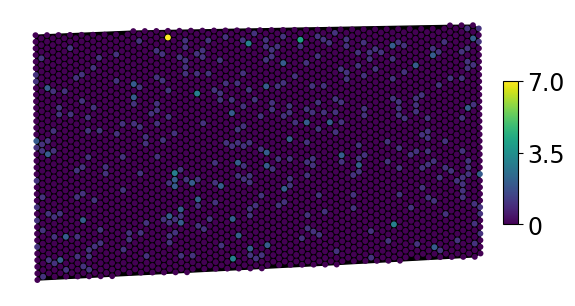

xe_rep2_tx


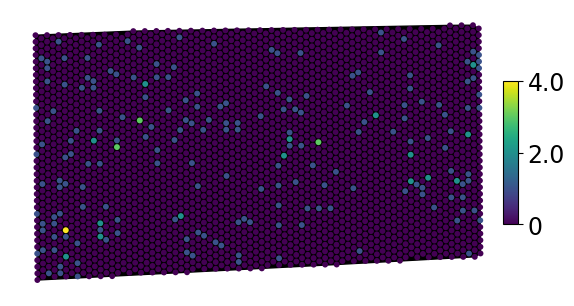

xe_rep1_cells


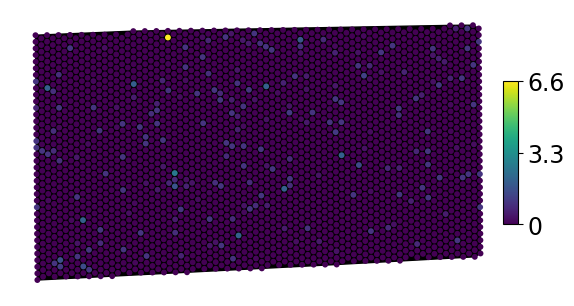

274
xe_rep2_cells vs xe_rep2_tx: 0.9957825069768721
visium vs xe_rep2_tx: 0.8671255954026413
visium vs xe_rep2_cells: 0.8722826112328058
xe_rep1_tx vs xe_rep2_tx: 0.9093326622295828
xe_rep1_tx vs xe_rep2_cells: 0.9103768675507385
xe_rep1_tx vs visium: 0.8678079553171679
xe_rep1_cells vs xe_rep2_tx: 0.9074628903097633
xe_rep1_cells vs xe_rep2_cells: 0.9111025158734875
xe_rep1_cells vs visium: 0.8796788307189695
xe_rep1_cells vs xe_rep1_tx: 0.9954884725171069
visium


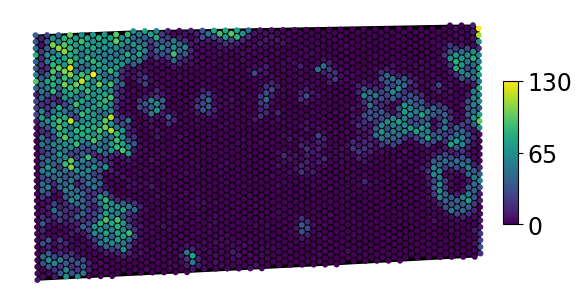

xe_rep1_tx


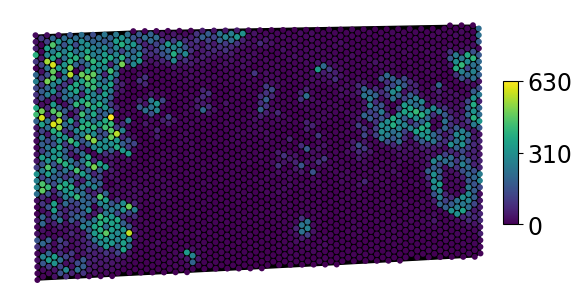

xe_rep2_tx


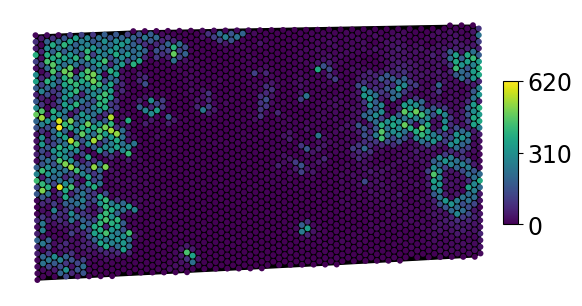

xe_rep1_cells


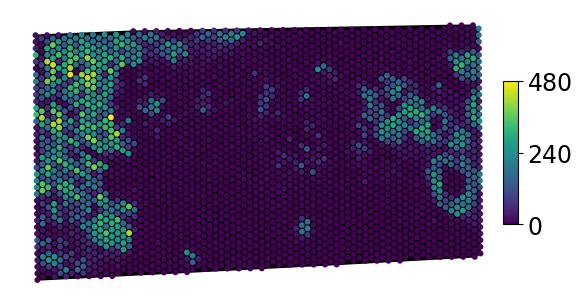

In [38]:
import matplotlib

for custom_gene in ["UCP1", "FOXA1"]:
    gene_index = visium_roi_sdata.table.var_names.tolist().index(custom_gene)
    print(gene_index)

    v = {}
    for layer in ["xe_rep2_tx", "xe_rep2_cells", "visium", "xe_rep1_tx", "xe_rep1_cells"]:
        v[layer] = visium_roi_sdata.table.layers[layer][:, gene_index]

    v["visium"] = v["visium"].toarray().flatten()

    for l0 in v.keys():
        for l1 in v.keys():
            if l0 == l1:
                break
            corr, _ = pearsonr(v[l0], v[l1])
            print(f"{l0} vs {l1}: {corr}")

    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    def one_sig_digits_large_numbers(x, pos):
        if x == 0:
            return "0"
        return f"{round(x, -int(np.floor(np.log10(abs(x))) - 1)):.0f}"
        # return "{:.1e}".format(x).replace("e+0", "e")

    def one_sig_digits_small_numbers(x, pos):
        if x == 0:
            return "0"
        return f"{x:.1f}"
        # return "{:.1e}".format(x).replace("e+0", "e")

    matplotlib.rcParams.update({"font.size": 17})
    for layer in ["visium", "xe_rep1_tx", "xe_rep2_tx", "xe_rep1_cells"]:
        print(layer)
        ax = plt.gca()
        ax.fill(box_x, box_y, c="k")
        sc.pl.spatial(
            visium_roi_sdata.table,
            img_key=None,
            library_id=None,
            spot_size=420,
            color=custom_gene,
            layer=layer,
            frameon=False,
            show=False,
            colorbar_loc=None,
            ax=ax,
            title="",
        )
        fig = plt.gcf()

        # Create a new inset axis for the colorbar
        cax = inset_axes(ax, width="3%", height="50%", loc="right", borderpad=-0.5)
        cbar = plt.colorbar(ax.collections[0], cax=cax)

        # Customize the colorbar ticks using LinearLocator
        cbar.locator = ticker.LinearLocator(numticks=3)
        cbar.update_ticks()

        # Format the ticks to show only 1 decimal digit
        # cbar.formatter = ticker.FormatStrFormatter('%.1f')
        # fast and ugly and dirty to get 2 significant digits for our two genes
        if custom_gene == "UCP1":
            cbar.formatter = ticker.FuncFormatter(one_sig_digits_small_numbers)
        if custom_gene == "FOXA1":
            cbar.formatter = ticker.FuncFormatter(one_sig_digits_large_numbers)
        # cbar.update_ticks()

        plt.show()

## Panel E

### Find cell types fractions from Xenium into polygonal ROIs

In [39]:
cell_types_categories = xe_rep1_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()

rois_fractions = {}
for row in landmarks_sdata["rois"].iterrows():
    name = row[1][-1]
    cells_inside = cells_in_rois_sdata_rep1[f"Shapes in ROI '{name}'"]
    indices_rep1 = cells_inside.index.tolist()
    corresponding_rows_mask = xe_rep1_roi_sdata.table.obs["cell_id"].isin(indices_rep1)
    corresponding_rows = xe_rep1_roi_sdata.table[corresponding_rows_mask]
    cell_types = corresponding_rows.obs["celltype_major"]
    empty = pd.Series(index=cell_types_categories, data=np.zeros(len(cell_types_categories), dtype=float))
    counts = cell_types.value_counts()
    empty.loc[counts.index] = counts
    rois_fractions[name] = empty
df1_rois = pd.DataFrame(rois_fractions).transpose()

In [40]:
cell_types_categories = xe_rep2_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()

rois_fractions = {}
for row in landmarks_sdata["rois"].iterrows():
    name = row[1][-1]
    cells_inside = cells_in_rois_sdata_rep2[f"Shapes in ROI '{name}'"]
    indices_rep2 = cells_inside.index.tolist()
    corresponding_rows_mask = xe_rep2_roi_sdata.table.obs["cell_id"].isin(indices_rep2)
    corresponding_rows = xe_rep2_roi_sdata.table[corresponding_rows_mask]
    cell_types = corresponding_rows.obs["celltype_major"]
    empty = pd.Series(index=cell_types_categories, data=np.zeros(len(cell_types_categories), dtype=float))
    counts = cell_types.value_counts()
    empty.loc[counts.index] = counts
    rois_fractions[name] = empty
df2_rois = pd.DataFrame(rois_fractions).transpose()

In [41]:
df1_rois

B-cells    CAFs  Cancer Epithelial  Endothelial  Myeloid   
Invasive                94.0  1534.0            12658.0       1544.0   1977.0  \
Immune infiltration    430.0   401.0                0.0        140.0    478.0   
DCIS                    11.0   230.0             4784.0        184.0    533.0   
Duct ectasia            11.0    35.0                4.0          6.0    196.0   

                     Normal Epithelial    PVL  Plasmablasts  T-cells  
Invasive                        1693.0  295.0         216.0   2449.0  
Immune infiltration                1.0   25.0         131.0   1191.0  
DCIS                            2256.0   69.0          13.0    222.0  
Duct ectasia                     550.0    0.0           2.0     65.0

In [42]:
df2_rois

B-cells    CAFs  Cancer Epithelial  Endothelial  Myeloid   
Invasive               128.0  1173.0            13685.0       1587.0   1846.0  \
Immune infiltration    500.0   336.0                0.0        125.0    481.0   
DCIS                     6.0   216.0             4938.0        193.0    495.0   
Duct ectasia             3.0    36.0                4.0         13.0    202.0   

                     Normal Epithelial    PVL  Plasmablasts  T-cells  
Invasive                         924.0  350.0         225.0   2430.0  
Immune infiltration                0.0   28.0         132.0   1242.0  
DCIS                            2037.0   61.0          14.0    207.0  
Duct ectasia                     549.0    4.0           3.0     84.0

### Find cell types fractions from Xenium into Visium clonal ROIs

In [43]:
from spatialdata import polygon_query

In [44]:
from geopandas import GeoSeries

visium_circles = visium_roi_sdata.shapes["CytAssist_FFPE_Human_Breast_Cancer"]

In [45]:
clone_sdatas_rep1 = {}

for clone in ["1", "2", "3"]:
    clone_rows = visium_roi_sdata.table[visium_roi_sdata.table.obs["clone"] == clone]
    merged = clone_rows.obs.merge(visium_circles, how="left", left_on="spot_id", right_index=True)
    clone_polygons = GeoSeries(merged.geometry).buffer(visium_circles.radius.iloc[0], 128).tolist()
    sdata = polygon_query(
        SpatialData(shapes={"cell_circles": xe_rep1_roi_sdata["cell_boundaries"]}, table=xe_rep1_roi_sdata.table),
        clone_polygons,
        "aligned",
        points=False,
    )
    clone_sdatas_rep1[clone] = sdata

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [02:05<00:00,  2.31it/s]


In [46]:
clone_sdatas_rep2 = {}

for clone in ["1", "2", "3"]:
    clone_rows = visium_roi_sdata.table[visium_roi_sdata.table.obs["clone"] == clone]
    merged = clone_rows.obs.merge(visium_circles, how="left", left_on="spot_id", right_index=True)
    clone_polygons = GeoSeries(merged.geometry).buffer(visium_circles.radius.iloc[0], 128).tolist()
    sdata = polygon_query(
        SpatialData(shapes={"cell_circles": xe_rep2_roi_sdata["cell_boundaries"]}, table=xe_rep2_roi_sdata.table),
        clone_polygons,
        "aligned",
        points=False,
    )
    clone_sdatas_rep2[clone] = sdata

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [02:03<00:00,  2.33it/s]


In [47]:
cell_types_categories = xe_rep1_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()

clones_fractions = {}
for name, sdata in clone_sdatas_rep1.items():
    indices_rep1 = sdata.shapes["cell_circles"].index.tolist()
    corresponding_rows_mask = xe_rep1_roi_sdata.table.obs["cell_id"].isin(indices_rep1)
    corresponding_rows = xe_rep1_roi_sdata.table[corresponding_rows_mask]
    cell_types = corresponding_rows.obs["celltype_major"]
    empty = pd.Series(index=cell_types_categories, data=np.zeros(len(cell_types_categories), dtype=float))
    counts = cell_types.value_counts()
    empty.loc[counts.index] = counts
    clones_fractions[f"Clone {name}"] = empty

df1_clones = pd.DataFrame(clones_fractions).transpose()

In [48]:
cell_types_categories = xe_rep2_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()

clones_fractions = {}
for name, sdata in clone_sdatas_rep2.items():
    indices_rep2 = sdata.shapes["cell_circles"].index.tolist()
    corresponding_rows_mask = xe_rep2_roi_sdata.table.obs["cell_id"].isin(indices_rep2)
    corresponding_rows = xe_rep2_roi_sdata.table[corresponding_rows_mask]
    cell_types = corresponding_rows.obs["celltype_major"]
    empty = pd.Series(index=cell_types_categories, data=np.zeros(len(cell_types_categories), dtype=float))
    counts = cell_types.value_counts()
    empty.loc[counts.index] = counts
    clones_fractions[f"Clone {name}"] = empty

df2_clones = pd.DataFrame(clones_fractions).transpose()

In [49]:
df1_clones

B-cells   CAFs  Cancer Epithelial  Endothelial  Myeloid   
Clone 1     22.0  684.0             8566.0        707.0    880.0  \
Clone 2     67.0  738.0             1918.0        518.0    828.0   
Clone 3     21.0  950.0             5020.0        391.0    716.0   

         Normal Epithelial    PVL  Plasmablasts  T-cells  
Clone 1             1045.0  109.0          46.0    739.0  
Clone 2             1147.0  145.0         114.0   1145.0  
Clone 3             2748.0   95.0          98.0    491.0

In [50]:
df2_clones

B-cells   CAFs  Cancer Epithelial  Endothelial  Myeloid   
Clone 1     26.0  558.0             9245.0        736.0    819.0  \
Clone 2     79.0  627.0             2163.0        525.0    741.0   
Clone 3     21.0  843.0             5244.0        421.0    657.0   

         Normal Epithelial    PVL  Plasmablasts  T-cells  
Clone 1              527.0  124.0          66.0    796.0  
Clone 2              924.0  190.0         138.0   1067.0  
Clone 3             2513.0  124.0          87.0    478.0

### Find cell types fractions for the Visium data

AnnData file with the result of cell types assignment (cell2location). [Can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/generated_data/xenium_visium_integration/visium_annotated_cell2location.h5ad).

In [51]:
VISIUM_CELL2LOCATION_PATH = os.path.join(GENERATED_DATA_PATH, "visium_annotated_cell2location.h5ad")

cell2location_adata = sc.read_h5ad(VISIUM_CELL2LOCATION_PATH)
cell2location_adata

AnnData object with n_obs × n_vars = 2829 × 270
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'dataset', 'ROI', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid', 'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial', 'spatialdata_attrs', 'wilcoxon'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'xe_rep1_celltype_major', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2_celltype_minor'
    layers: 'xe_rep1_tx', 'xe_rep2_tx'

In [52]:
obs_names = cell2location_adata.obs["spot_id"].to_numpy()

In [53]:
cell_types_categories = xe_rep1_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()
columns = [cell2location_adata.obs[c] for c in cell_types_categories]
x = np.stack(columns).T
print(x.shape)
obs = pd.DataFrame(index=obs_names)
var = pd.DataFrame(index=cell_types_categories)
visium_celltypes_adata = AnnData(x, obs=obs, var=var)

(2829, 9)


In [54]:
import pandas as pd
from spatialdata.models import TableModel

visium_circles_in_rois_sdata = get_shapes_in_rois_sdata(
    sdata=visium_roi_sdata,
    shapes_name="CytAssist_FFPE_Human_Breast_Cancer",
    rois=landmarks_sdata["rois"],
    instance_key="spot_id",
)
visium_circles_in_rois_sdata

SpatialData object with:
├── Shapes
│     ├── "Shapes in ROI 'DCIS'": GeoDataFrame shape: (172, 2) (2D shapes)
│     ├── "Shapes in ROI 'Duct ectasia'": GeoDataFrame shape: (19, 2) (2D shapes)
│     ├── "Shapes in ROI 'Immune infiltration'": GeoDataFrame shape: (41, 2) (2D shapes)
│     └── "Shapes in ROI 'Invasive'": GeoDataFrame shape: (477, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 709 × 307
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    uns: 'spatialdata_attrs'
    obsm: 'spatial', 'xe_rep1_celltype_major', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2_celltype_minor'
    layers: 'xe_rep1_cells', 'xe_rep1_tx', 'xe_rep2_cells', 'xe_rep2_tx', 'visium', 'xe_rep1_tx_log', 'xe_rep2_tx_log': AnnData (709, 307)
with coordinate systems:
▸ 'aligned', with elements:
        Shapes in ROI 'DCIS' (Shapes), Shapes in ROI 'Duct ectasia' (Shapes), Shapes in ROI 'Immune infiltration' (Shapes), Shapes in ROI '

In [55]:
cell_types_categories = xe_rep1_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()

rois_fractions = {}
for row in landmarks_sdata["rois"].iterrows():
    name = row[1][-1]
    circles_inside = visium_circles_in_rois_sdata[f"Shapes in ROI '{name}'"]
    indices_circles = circles_inside.index.tolist()
    corresponding_rows_mask = visium_celltypes_adata.obs.index.astype(int).isin(indices_circles)
    corresponding_rows = visium_celltypes_adata[corresponding_rows_mask]

    counts = np.sum(corresponding_rows.X, axis=0).copy()
    empty = pd.Series(index=cell_types_categories, data=counts, dtype=float)
    rois_fractions[name] = empty
df3_rois = pd.DataFrame(rois_fractions).transpose()
df3_rois

B-cells       CAFs  Cancer Epithelial  Endothelial   
Invasive             11.693720  32.444407        5155.228895    58.585124  \
Immune infiltration  18.217613   8.356017           7.968343     1.153179   
DCIS                  1.061500   8.554866        2348.546248     4.952525   
Duct ectasia          2.382595   1.915322           1.208508     0.449398   

                       Myeloid  Normal Epithelial        PVL  Plasmablasts   
Invasive             32.162699         159.874049  10.186672     10.584536  \
Immune infiltration   6.993101           3.344168   0.332606      2.841154   
DCIS                 21.808709         114.850440   2.542077      4.496787   
Duct ectasia         29.657908          15.559059   0.256359      0.549000   

                       T-cells  
Invasive             70.621718  
Immune infiltration  24.359494  
DCIS                  7.273899  
Duct ectasia          4.458180

In [56]:
clones_fractions = {}

for clone in ["1", "2", "3"]:
    clone_rows = visium_roi_sdata.table[visium_roi_sdata.table.obs["clone"] == clone]
    circle_id = clone_rows.obs["spot_id"].tolist()
    mask = visium_celltypes_adata.obs.index.astype(int).isin(circle_id)
    corresponding_rows = visium_celltypes_adata[mask]

    counts = np.sum(corresponding_rows.X, axis=0).copy()
    empty = pd.Series(index=cell_types_categories, data=counts, dtype=float)
    clones_fractions[f"Clone {clone}"] = empty

df3_clones = pd.DataFrame(clones_fractions).transpose()
df3_clones

B-cells       CAFs  Cancer Epithelial  Endothelial    Myeloid   
Clone 1  2.975529  15.884820        5555.304218    38.862368  14.463024  \
Clone 2  7.455300  29.163825        1203.760163    27.074860  26.890034   
Clone 3  2.522370  23.611018        3742.105385    10.839880  23.815948   

         Normal Epithelial       PVL  Plasmablasts    T-cells  
Clone 1         178.999318  5.439429      3.037373  25.497974  
Clone 2          57.895280  7.658463      7.694769  51.611406  
Clone 3         201.607150  4.931156     10.238655  17.414389

### Plot the fractions

In [57]:
df1 = pd.concat([df1_rois, df1_clones])
df2 = pd.concat([df2_rois, df2_clones])
df3 = pd.concat([df3_rois, df3_clones])

In [58]:
df1

B-cells    CAFs  Cancer Epithelial  Endothelial  Myeloid   
Invasive                94.0  1534.0            12658.0       1544.0   1977.0  \
Immune infiltration    430.0   401.0                0.0        140.0    478.0   
DCIS                    11.0   230.0             4784.0        184.0    533.0   
Duct ectasia            11.0    35.0                4.0          6.0    196.0   
Clone 1                 22.0   684.0             8566.0        707.0    880.0   
Clone 2                 67.0   738.0             1918.0        518.0    828.0   
Clone 3                 21.0   950.0             5020.0        391.0    716.0   

                     Normal Epithelial    PVL  Plasmablasts  T-cells  
Invasive                        1693.0  295.0         216.0   2449.0  
Immune infiltration                1.0   25.0         131.0   1191.0  
DCIS                            2256.0   69.0          13.0    222.0  
Duct ectasia                     550.0    0.0           2.0     65.0  
Clone 1                         1045.0  109.0          46.0    739.0  
Clone 2                         1147.0  145.0         114.0   1145.0  
Clone 3                         2748.0   95.0          98.0    491.0

In [59]:
df2

B-cells    CAFs  Cancer Epithelial  Endothelial  Myeloid   
Invasive               128.0  1173.0            13685.0       1587.0   1846.0  \
Immune infiltration    500.0   336.0                0.0        125.0    481.0   
DCIS                     6.0   216.0             4938.0        193.0    495.0   
Duct ectasia             3.0    36.0                4.0         13.0    202.0   
Clone 1                 26.0   558.0             9245.0        736.0    819.0   
Clone 2                 79.0   627.0             2163.0        525.0    741.0   
Clone 3                 21.0   843.0             5244.0        421.0    657.0   

                     Normal Epithelial    PVL  Plasmablasts  T-cells  
Invasive                         924.0  350.0         225.0   2430.0  
Immune infiltration                0.0   28.0         132.0   1242.0  
DCIS                            2037.0   61.0          14.0    207.0  
Duct ectasia                     549.0    4.0           3.0     84.0  
Clone 1                          527.0  124.0          66.0    796.0  
Clone 2                          924.0  190.0         138.0   1067.0  
Clone 3                         2513.0  124.0          87.0    478.0

In [60]:
df3

B-cells       CAFs  Cancer Epithelial  Endothelial   
Invasive             11.693720  32.444407        5155.228895    58.585124  \
Immune infiltration  18.217613   8.356017           7.968343     1.153179   
DCIS                  1.061500   8.554866        2348.546248     4.952525   
Duct ectasia          2.382595   1.915322           1.208508     0.449398   
Clone 1               2.975529  15.884820        5555.304218    38.862368   
Clone 2               7.455300  29.163825        1203.760163    27.074860   
Clone 3               2.522370  23.611018        3742.105385    10.839880   

                       Myeloid  Normal Epithelial        PVL  Plasmablasts   
Invasive             32.162699         159.874049  10.186672     10.584536  \
Immune infiltration   6.993101           3.344168   0.332606      2.841154   
DCIS                 21.808709         114.850440   2.542077      4.496787   
Duct ectasia         29.657908          15.559059   0.256359      0.549000   
Clone 1              14.463024         178.999318   5.439429      3.037373   
Clone 2              26.890034          57.895280   7.658463      7.694769   
Clone 3              23.815948         201.607150   4.931156     10.238655   

                       T-cells  
Invasive             70.621718  
Immune infiltration  24.359494  
DCIS                  7.273899  
Duct ectasia          4.458180  
Clone 1              25.497974  
Clone 2              51.611406  
Clone 3              17.414389

In [61]:
# Normalize the data by row to make each bar's height the same
df1 = df1.div(df1.sum(axis=1), axis=0)
df2 = df2.div(df2.sum(axis=1), axis=0)
df3 = df3.div(df3.sum(axis=1), axis=0)

In [62]:
df1_copy = df1.copy()
df2_copy = df2.copy()
df3_copy = df3.copy()

df1 = df1.loc[["Immune infiltration", "Clone 1"], :]
df2 = df2.loc[["Immune infiltration", "Clone 1"], :]
df3 = df3.loc[["Immune infiltration", "Clone 1"], :]

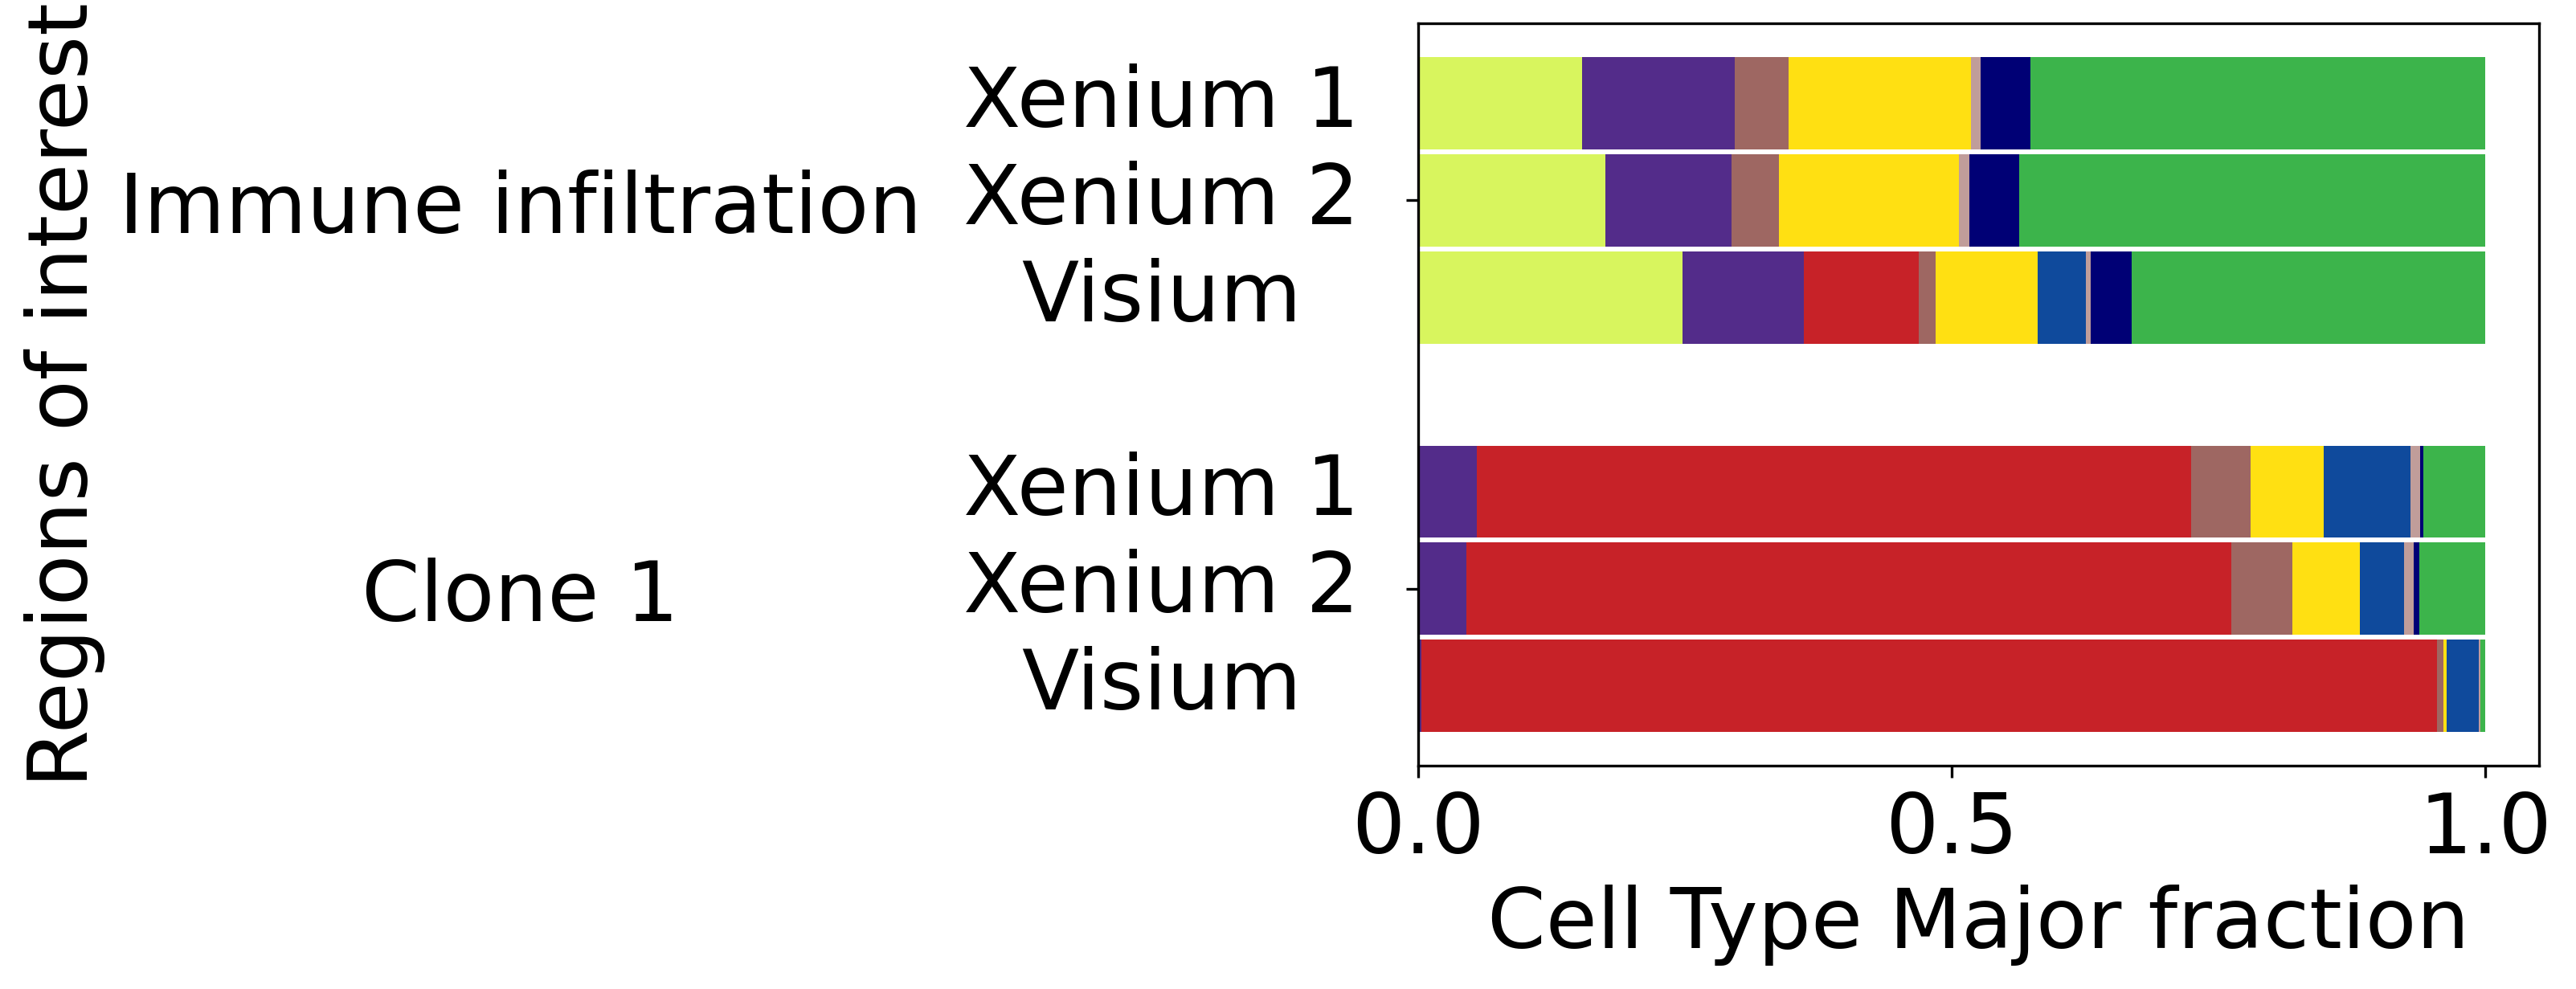

In [63]:
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Normalize the data by row to make each bar's height the same
df1 = df1.div(df1.sum(axis=1), axis=0)
df2 = df2.div(df2.sum(axis=1), axis=0)
df3 = df3.div(df3.sum(axis=1), axis=0)

# Define the custom colors
cell_types_categories = xe_rep1_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()
colors = xe_rep1_roi_sdata.table.uns["celltype_major_colors"]
regions_names = df1.index.tolist()
# replace last df with visium one
dataframes = [df1, df2, df3]
dataframes_names = ["Xenium 1", "Xenium 2", "Visium"]

# Set the width of a bar
bar_width = 0.35

# Positions of the bars on the y-axis
ind = np.arange(len(df1.index))

# Create the grouped bar plot using Pandas
matplotlib.rcParams.update({"font.size": 25})
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
cumulative_bars = [np.zeros(len(regions_names)) for _ in range(len(dataframes))]
for i, cell_type in enumerate(cell_types_categories):
    bar_width = 0.25

    for j, df in enumerate(dataframes):
        previous = cumulative_bars[j]
        y_values = bar_width * (np.arange(len(regions_names)) * (len(dataframes) + 1) + (len(dataframes) + j))
        x_values = df.loc[:, cell_type].to_numpy()
        ax.barh(y_values, x_values, bar_width * 0.95, color=colors[i], left=previous)
        cumulative_bars[j] += x_values

        # Add the labels below each bar
        if i == 0:
            for k, y in enumerate(y_values):
                ax.text(-0.24, y, dataframes_names[j], ha="center", va="center", rotation=0)


# Customize the plot
ax.set_yticks(bar_width * (np.arange(len(regions_names)) * (len(dataframes) + 1) + len(dataframes) / 2 + 2.5))
yticklabels = ax.set_yticklabels(regions_names, rotation=0, ha="center")
for label in yticklabels:
    label.set_x(-0.78)  # Adjust the x value to position the labels lower

ax.set_ylabel("Regions of interest")
ax.set_xlabel("Cell Type Major fraction")
ax.invert_yaxis()

# Create custom patches for the legend
legend_patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, cell_types_categories)]

# Add the custom legend to the plot
# ax.legend(handles=legend_patches, title='Cell Type Major', bbox_to_anchor=(1, 1), ncol=9)
plt.show()

## Computing the Pearson correlation between cell-types

In [64]:
spot_id_visium_cell2location = cell2location_adata.obs["spot_id"].to_numpy()

In [65]:
assert np.array_equal(visium_celltypes_adata.obs.index.to_numpy(), spot_id_visium_cell2location.astype(str))

In [66]:
spot_id_visium_sdata = visium_roi_sdata.table.obs.spot_id.to_numpy()

In [67]:
print(set(spot_id_visium_cell2location).difference(set(spot_id_visium_sdata)))
print(set(spot_id_visium_sdata).difference(set(spot_id_visium_cell2location)))

{2378, 2236, 4022, 4834}
{4174}


In [68]:
common_ids = np.intersect1d(spot_id_visium_cell2location, spot_id_visium_sdata)

In [69]:
visium_roi_sdata_common = np.where(visium_roi_sdata.table.obs.spot_id.isin(common_ids))[0]
cell2location_adata_common = np.where(cell2location_adata.obs.spot_id.isin(common_ids))[0]

In [70]:
visium_celltypes_adata_roi = visium_celltypes_adata[common_ids.astype(str)]

In [71]:
a0 = visium_celltypes_adata_roi.X.copy()

In [72]:
a1 = visium_roi_sdata.table.obsm["xe_rep1_celltype_major"]

In [73]:
a2 = visium_roi_sdata.table.obsm["xe_rep2_celltype_major"]

In [74]:
print(a0.shape)

(2825, 9)


### Pearson's R for cell types agreement between Xenium rep1 and Xenium rep2

In [75]:
# one correlation per Visium circle, each correlation is computed between two 9 dimensional vectors
correlations_12 = compute_correlations(a1, a2, axis=0)

In [76]:
print(correlations_12.shape)

(2826,)


In [77]:
print(np.sum(np.isnan(correlations_12)))

63


In [78]:
np.nanmedian(correlations_12)

0.8037999657372997

In [79]:
np.nanmean(correlations_12)

0.6808950156151656

### Pearson's R for cell types agreement between Visium and Xenium rep1

In [80]:
correlations_01 = compute_correlations(a0, a1, axis=0)

In [81]:
print(correlations_01.shape)

(2825,)


In [82]:
print(np.sum(np.isnan(correlations_01)))

38


In [83]:
np.nanmedian(correlations_01)

0.6573378928276101

In [84]:
np.nanmean(correlations_01)

0.5512989577163583

### Pearson's R for cell types agreement between Visium and Xenium rep2

In [85]:
correlations_02 = compute_correlations(a0, a2, axis=0)

In [86]:
print(correlations_02.shape)

(2825,)


In [87]:
np.nanmedian(correlations_02)

0.6630409591604458

In [88]:
np.nanmean(correlations_02)

0.5553089723667032